------

In [ ]:
# OneDrive remote volume for data ~40GB
# !rclone mount onedrive: ~/onedrive --vfs-cache-mode writes

-----

In [148]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
matplotlib.rcParams['figure.dpi'] = 360
matplotlib.rcParams['text.usetex'] = True
rc("animation", html = "jshtml")
from matplotlib.colors import ListedColormap
# plt.style.use('dark_background')

from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp

import os
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
from pathlib import Path

In [149]:
import os
import sys
import subprocess

import numpy as np

from astropy.io import fits
from astropy.convolution import convolve, Gaussian1DKernel

from desimodel.footprint import radec2pix      # For getting healpix values #! install one by one
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# DESI targeting masks -
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask    # For SV3
from desitarget.targets import desi_mask

from astropy.io import fits
from astropy.table import Table as t

plt.style.use('./plots/desi.mplstyle')

In [150]:
data_path = '/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative'

----

### Data

In [104]:
with fits.open('/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative/10256/20211110/coadd-6-10256-thru20211110.fits') as hdu:
    table = t(hdu['FIBERMAP'].data)

table[:5]

<Table length=5>
     TARGETID     PETAL_LOC DEVICE_LOC ... MEAN_FIBER_X MEAN_FIBER_Y
      int64         int16     int32    ...   float32      float32   
----------------- --------- ---------- ... ------------ ------------
39627598921205758         6        523 ...      -273.15      293.209
39627592927548911         6        474 ...     -246.453      279.815
       -102566510         6        510 ...     -269.525      281.877
39627592919159653         6        225 ...     -110.606      262.366
39627592931737923         6        493 ...     -255.829      281.868

In [105]:
table.columns

<TableColumns names=('TARGETID','PETAL_LOC','DEVICE_LOC','LOCATION','FIBER','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','LAMBDA_REF','FA_TARGET','FA_TYPE','OBJTYPE','FIBERASSIGN_X','FIBERASSIGN_Y','PRIORITY','SUBPRIORITY','OBSCONDITIONS','RELEASE','BRICKNAME','BRICKID','BRICK_OBJID','MORPHTYPE','EBV','FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','FLUX_IVAR_W1','FLUX_IVAR_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','MASKBITS','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','PHOTSYS','PRIORITY_INIT','NUMOBS_INIT','DESI_TARGET','BGS_TARGET','MWS_TARGET','SCND_TARGET','PLATE_RA','PLATE_DEC','TILEID','COADD_NUMEXP','COADD_EXPTIME','COADD_NUMNIGHT','COADD_NUMTILE','MEAN_DELTA_X','RMS_DELTA_X','MEAN_DELTA_Y','RMS_DELTA_Y','MEAN_FIBER_RA','STD_FIBER_RA','MEAN_FIBER_DEC','STD_FIBE

### Bitmask

In [32]:
from desitarget.targets import desi_mask, bgs_mask, mws_mask
print(desi_mask)

desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 2}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3000, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 2}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3400, 'MORE_ZGOOD': 3350, 'MORE_ZWARN': 3300, 'MORE_MIDZQSO': 100, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 4}]
  - [QSO_HIZ,          4, "QSO selected using high-redshift Random Forest (informational bit)", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 0, 'DONE': 0, 'OBS': 0, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0, 'MORE_ZWARN': 0, 'MORE_ZGOOD': 0}, 'numobs': -1}]
  - [ELG_LOP,          5, "ELG at standard (ELG) priority", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3100, 'MORE_ZGOOD': 2,

In [33]:
names = desi_mask.names()
bitnums = [desi_mask.bitnum(name) for name in names]
bitvals = [desi_mask[name] for name in names]
list(zip(names,bitnums,bitvals)) # ADM the bit and integer value for each defined name.

[('LRG', 0, 1),
 ('ELG', 1, 2),
 ('QSO', 2, 4),
 ('QSO_HIZ', 4, 16),
 ('ELG_LOP', 5, 32),
 ('ELG_HIP', 6, 64),
 ('ELG_VLO', 7, 128),
 ('LRG_NORTH', 8, 256),
 ('ELG_NORTH', 9, 512),
 ('QSO_NORTH', 10, 1024),
 ('ELG_LOP_NORTH', 11, 2048),
 ('ELG_VLO_NORTH', 12, 4096),
 ('LRG_SOUTH', 16, 65536),
 ('ELG_SOUTH', 17, 131072),
 ('QSO_SOUTH', 18, 262144),
 ('ELG_LOP_SOUTH', 19, 524288),
 ('ELG_VLO_SOUTH', 20, 1048576),
 ('SKY', 32, 4294967296),
 ('STD_FAINT', 33, 8589934592),
 ('STD_WD', 34, 17179869184),
 ('STD_BRIGHT', 35, 34359738368),
 ('BAD_SKY', 36, 68719476736),
 ('SUPP_SKY', 37, 137438953472),
 ('NO_TARGET', 49, 562949953421312),
 ('BRIGHT_OBJECT', 50, 1125899906842624),
 ('IN_BRIGHT_OBJECT', 51, 2251799813685248),
 ('NEAR_BRIGHT_OBJECT', 52, 4503599627370496),
 ('BGS_ANY', 60, 1152921504606846976),
 ('MWS_ANY', 61, 2305843009213693952),
 ('SCND_ANY', 62, 4611686018427387904)]

In [34]:
targ = table[125] #target from row 125
desi_mask.names(targ["DESI_TARGET"])

['ELG', 'ELG_LOP', 'ELG_SOUTH', 'ELG_LOP_SOUTH']

----

### Tiles

In [109]:
path = Path('./plots/tiles/')
path.mkdir(parents=True, exist_ok=True)

In [110]:
tile = [f for f in os.listdir('/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative/10256/20211110/') if f.startswith('coadd-')]
tile

['coadd-0-10256-thru20211110.fits',
 'coadd-1-10256-thru20211110.fits',
 'coadd-2-10256-thru20211110.fits',
 'coadd-3-10256-thru20211110.fits',
 'coadd-4-10256-thru20211110.fits',
 'coadd-5-10256-thru20211110.fits',
 'coadd-6-10256-thru20211110.fits',
 'coadd-7-10256-thru20211110.fits',
 'coadd-8-10256-thru20211110.fits',
 'coadd-9-10256-thru20211110.fits']

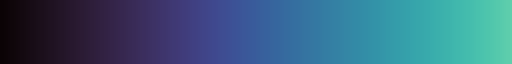

In [125]:
# plt.style.use('default')
palette = sns.color_palette("mako", 10)
palette

In [38]:
tiles_id = os.listdir(data_path)
nights = [os.listdir(data_path + '/' + tiles_id[i])[0] for i in range(len(tiles_id))]
tiles_id

['10256', '2436', '5568']

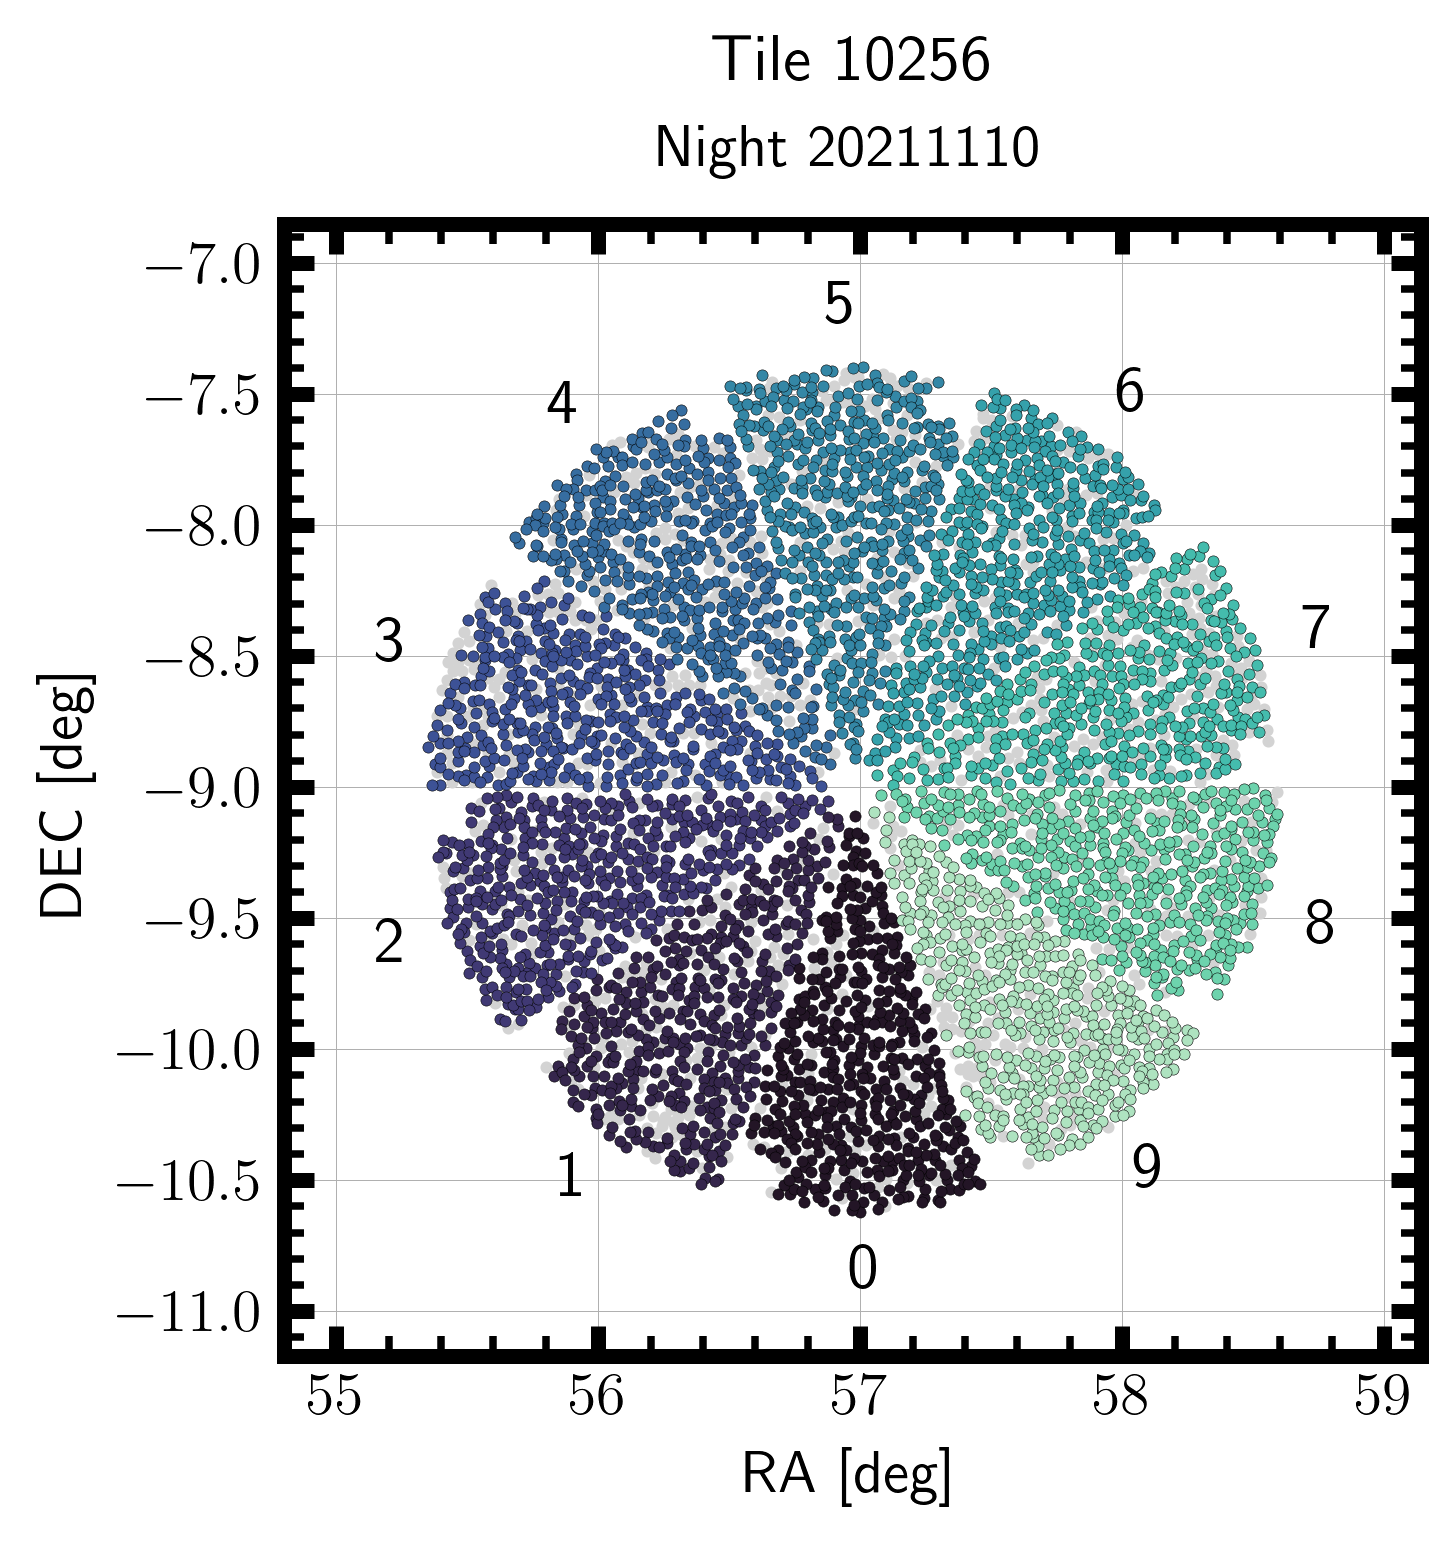

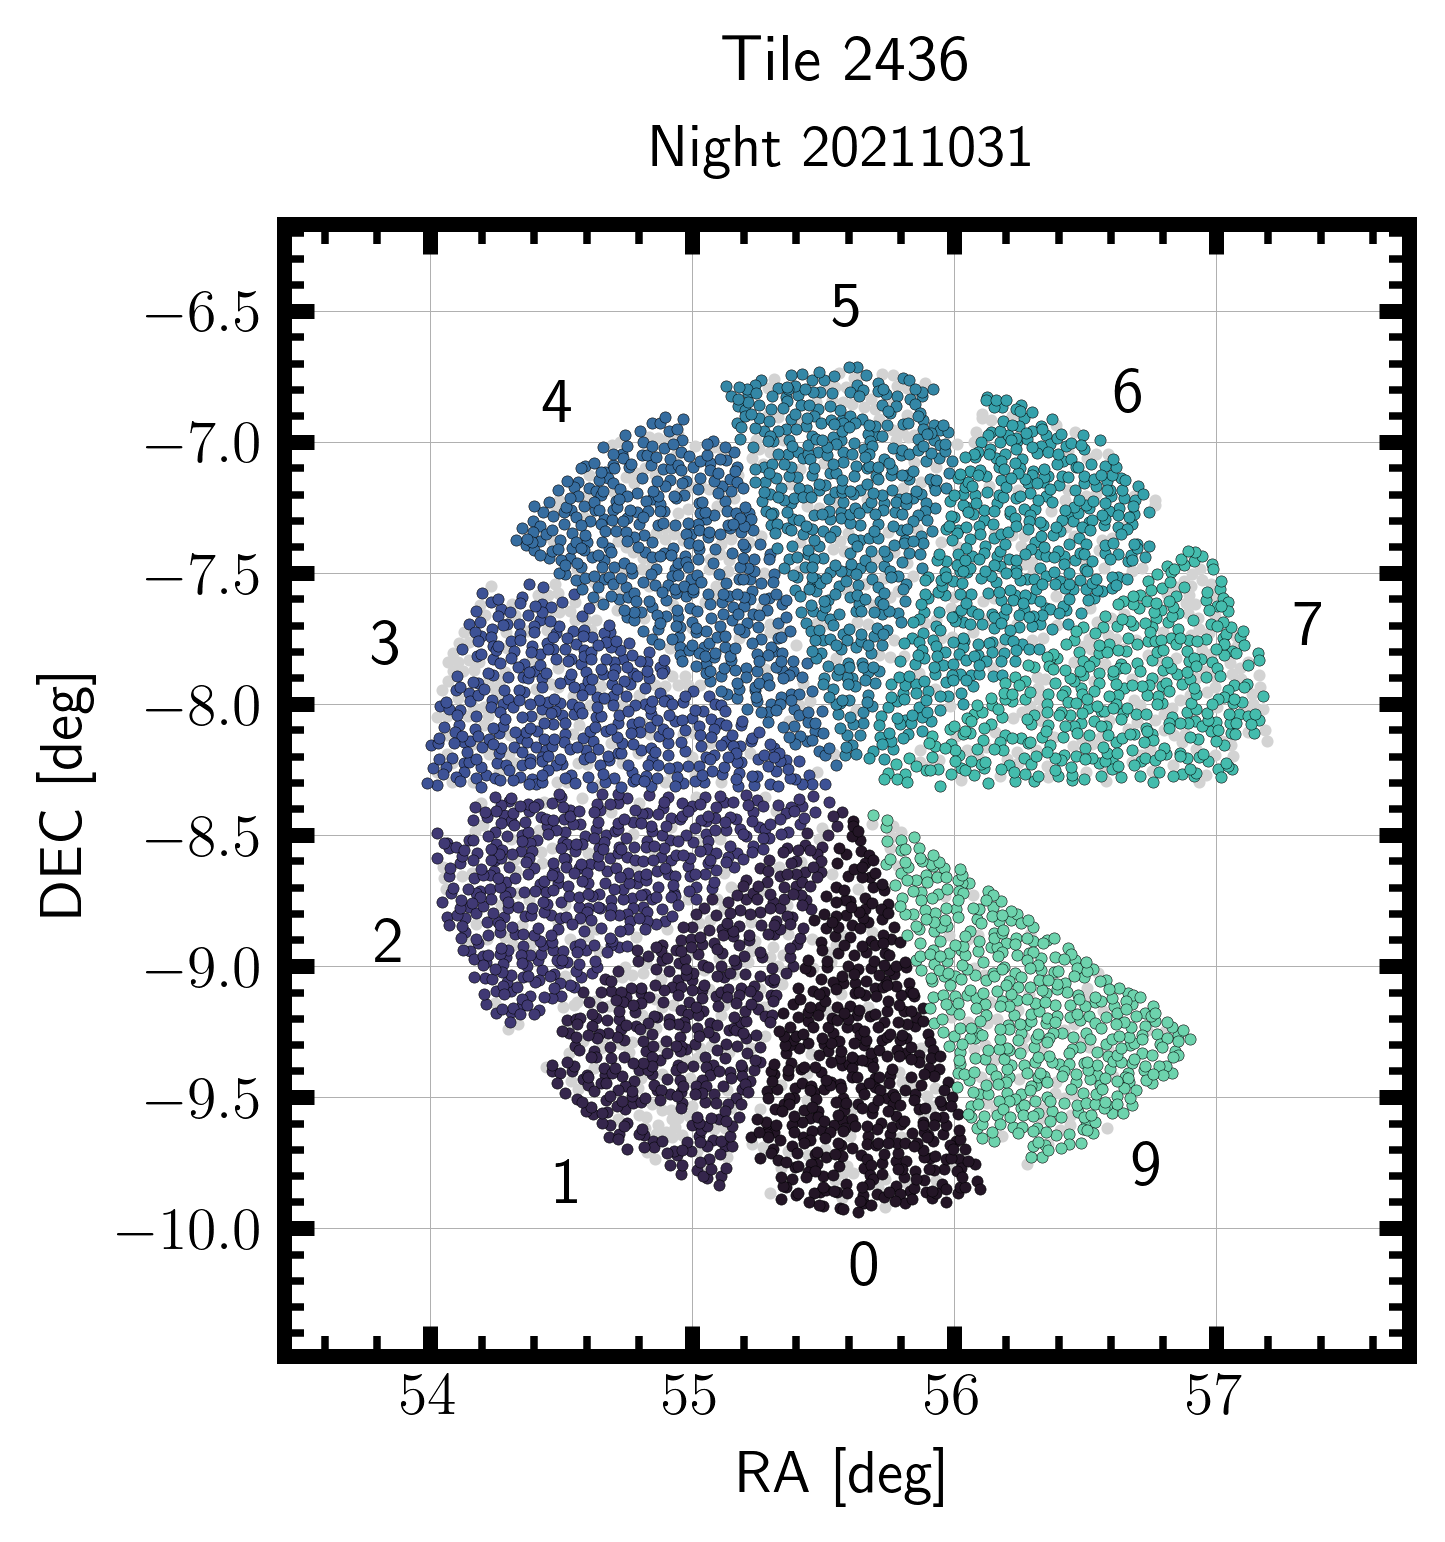

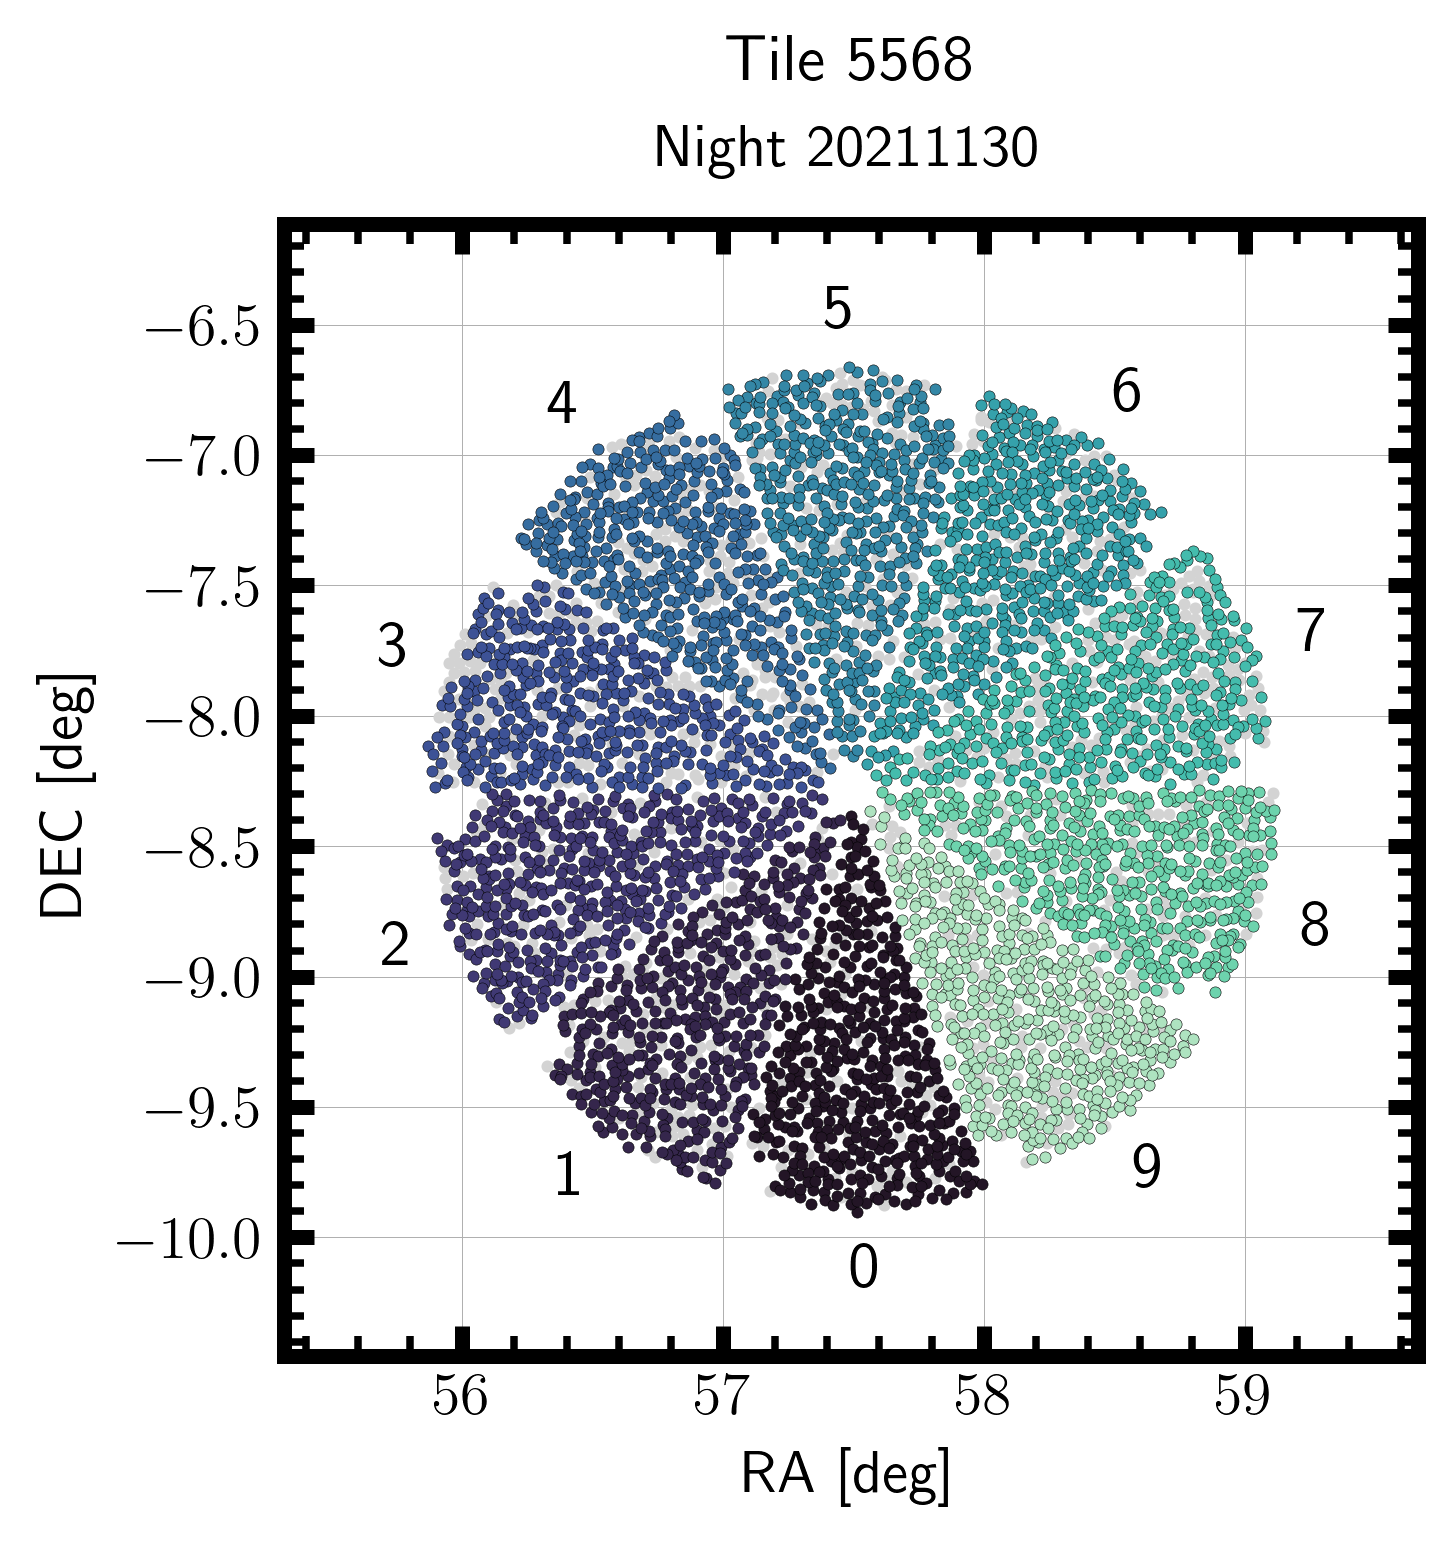

In [169]:
for i, night in enumerate(nights):

    tile = [f for f in os.listdir(f'{data_path}/{tiles_id[i]}/{night}') if f.startswith('coadd-')]

    fig, ax = plt.subplots()
    for j, petal in enumerate(tile):
        data = fits.open(f'{data_path}/{tiles_id[i]}/{night}/{petal}')['FIBERMAP'].data

        ax.scatter(data['TARGET_RA'], data['TARGET_DEC'], s=2, c='lightgrey', zorder=5)

        mask = np.logical_and(data['COADD_FIBERSTATUS']==0, data['DESI_TARGET']!=0)
        ax.scatter(data[mask]['TARGET_RA'], data[mask]['TARGET_DEC'], s=5, c=[palette[j]],
                   zorder=10, edgecolor='black', linewidth=0.1)

        mean_ra, mean_dec = data['TARGET_RA'].mean(), data['TARGET_DEC'].mean()
        d = np.sqrt((data['TARGET_RA'] - mean_ra)**2 + (data['TARGET_DEC'] - mean_dec)**2)
        edge_ra, edge_dec = data['TARGET_RA'][np.argmax(d)], data['TARGET_DEC'][np.argmax(d)]
        ax.text(mean_ra - 0.8 * (edge_ra - mean_ra), mean_dec - 0.8 * (edge_dec - mean_dec),
                data['PETAL_LOC'][0], fontsize=13, fontweight='bold', color='black',
                ha='center', va='center')

    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.margins(x=0.17, y=0.17)

    plt.title(f"Tile {data['TILEID'][0]}", y=1.1, fontdict={'fontsize': 13})
    ax.text(0.5, 1.05, f'Night {night}', fontsize=12, ha='center', transform=ax.transAxes)

    plt.grid(linewidth=0.2, zorder=0)
    plt.xlabel('RA [deg]', fontsize=12)
    plt.ylabel('DEC [deg]', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'./plots/tiles/tile_{data['TILEID'][0]}_{night}.png', dpi=360)
    plt.show()


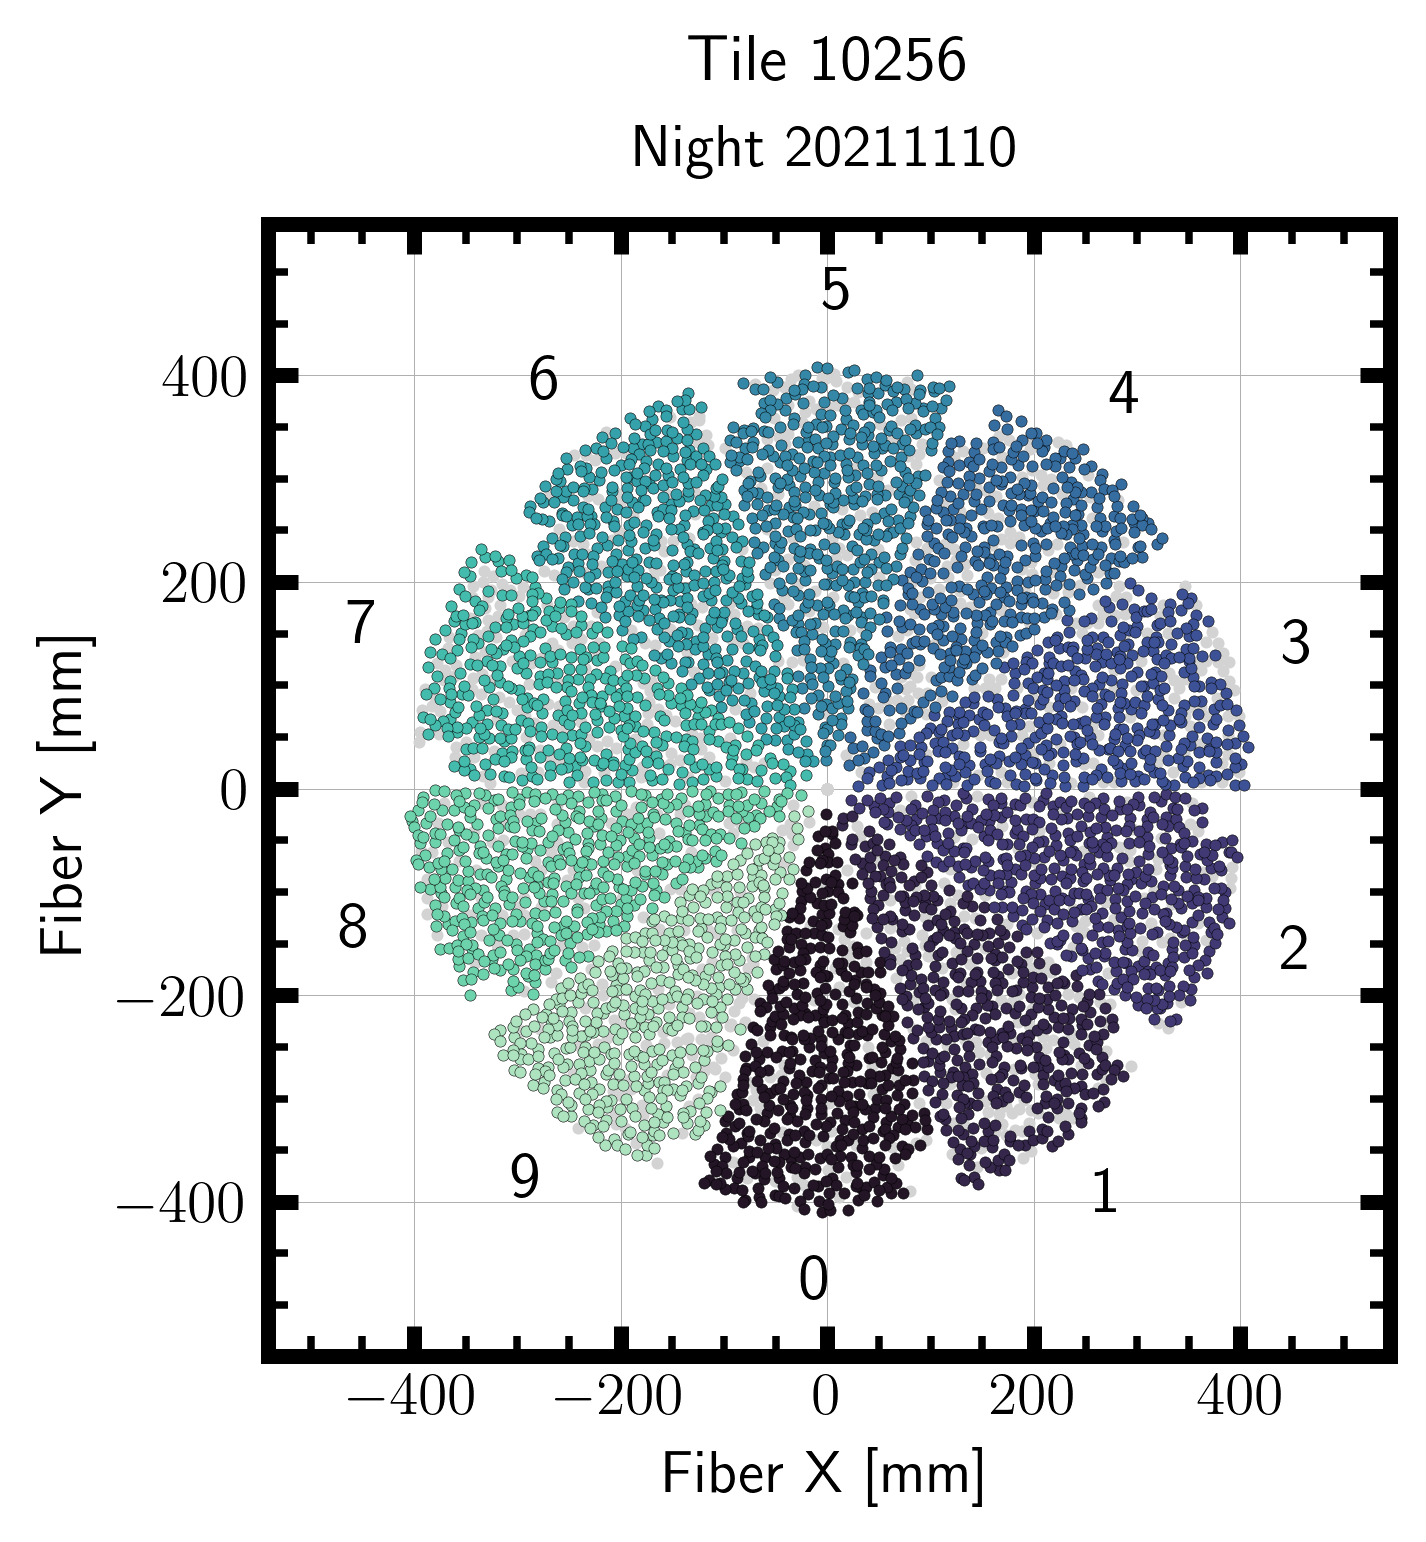

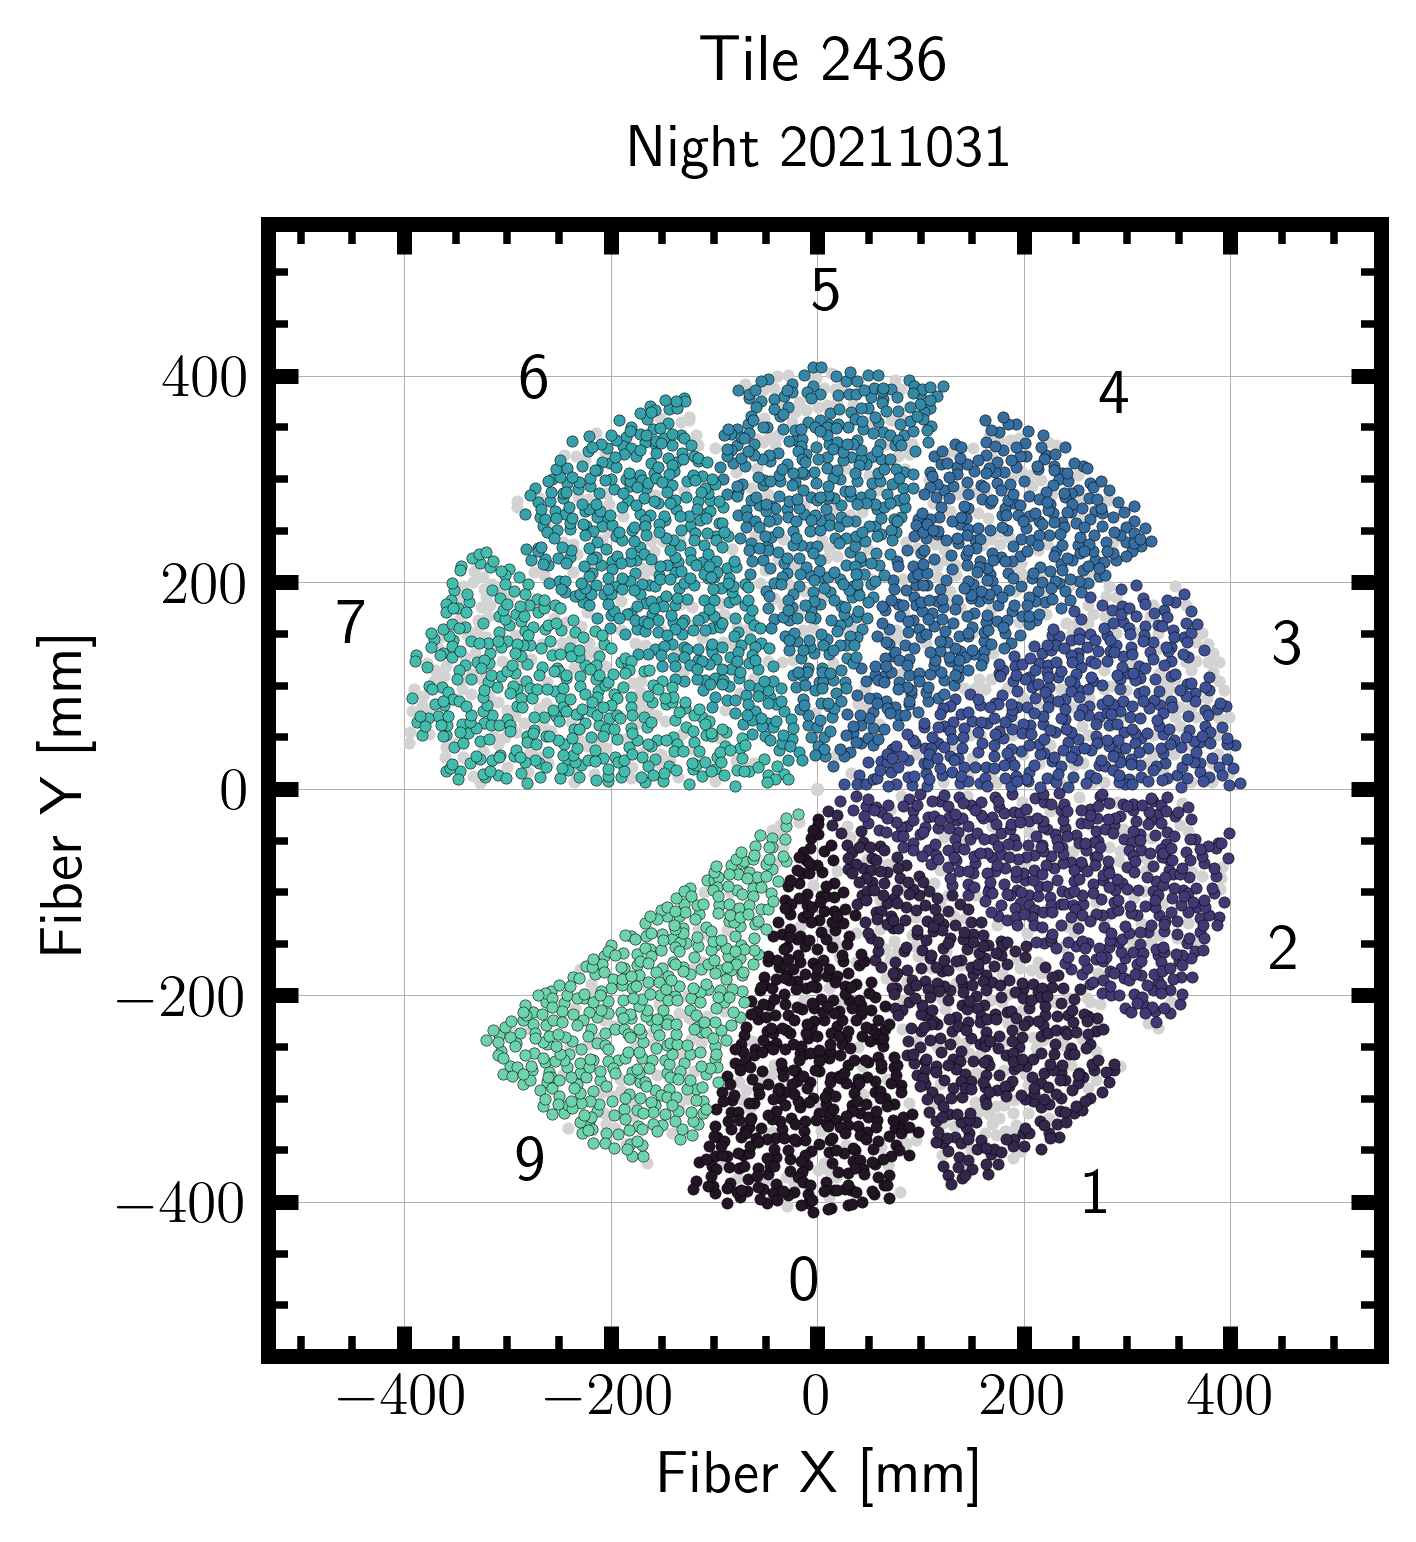

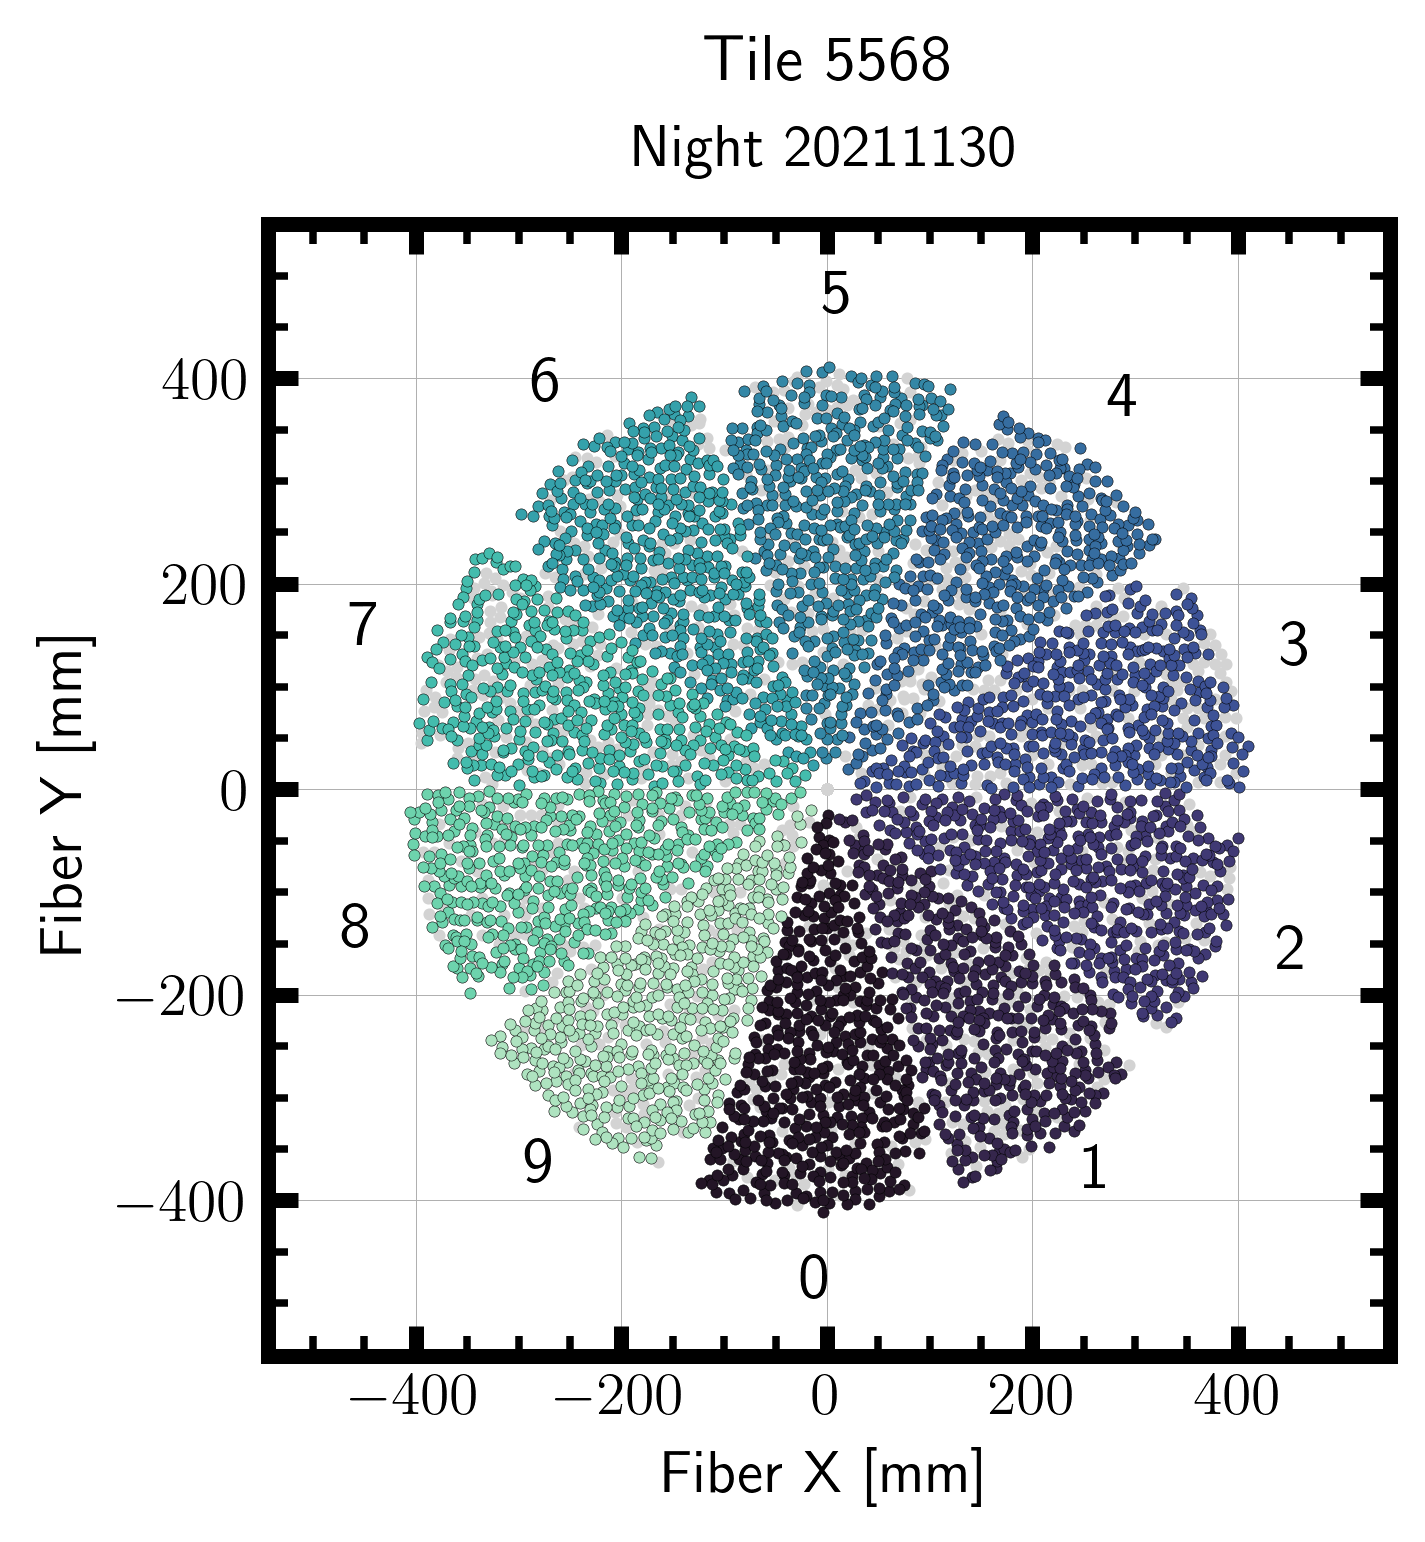

In [170]:
for i, night in enumerate(nights):

    tile = [f for f in os.listdir(f'{data_path}/{tiles_id[i]}/{night}') if f.startswith('coadd-')]

    fig, ax = plt.subplots()
    for j, petal in enumerate(tile):
        data = fits.open(f'{data_path}/{tiles_id[i]}/{night}/{petal}')['FIBERMAP'].data

        ax.scatter(data['MEAN_FIBER_X'], data['MEAN_FIBER_Y'], s=2, c='lightgrey', zorder=5)

        mask = np.logical_and(data['COADD_FIBERSTATUS']==0, data['DESI_TARGET']!=0)
        ax.scatter(data[mask]['MEAN_FIBER_X'], data[mask]['MEAN_FIBER_Y'], s=5, c=[palette[j]],
                   zorder=10, edgecolor='black', linewidth=0.1)

        mean_ra, mean_dec = data['MEAN_FIBER_X'].mean(), data['MEAN_FIBER_Y'].mean()
        d = np.sqrt((data['MEAN_FIBER_X'] - mean_ra)**2 + (data['MEAN_FIBER_Y'] - mean_dec)**2)
        edge_ra, edge_dec = data['MEAN_FIBER_X'][np.argmax(d)], data['MEAN_FIBER_Y'][np.argmax(d)]
        ax.text(mean_ra - 0.8 * (edge_ra - mean_ra), mean_dec - 0.8 * (edge_dec - mean_dec),
                data['PETAL_LOC'][0], fontsize=13, fontweight='bold', color='black',
                ha='center', va='center')

    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.margins(x=0.17, y=0.17)

    plt.title(f"Tile {data['TILEID'][0]}", y=1.1, fontdict={'fontsize': 13})
    ax.text(0.5, 1.05, f'Night {night}', fontsize=12, ha='center', transform=ax.transAxes)

    plt.grid(linewidth=0.2, zorder=0)
    plt.xlabel('Fiber X [mm]', fontsize=12)
    plt.ylabel('Fiber Y [mm]', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'./plots/tiles/tile_fiber_{data['TILEID'][0]}_{night}.png', dpi=360)
    plt.show()


----

### Spectra

Nights
1. 20211110 - 10256
2. 20211031 - 2436
3. 20211130 - 5568

In [111]:
#read combined spectra
coadd_obj = desispec.io.read_spectra(f'/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative/10256/20211110/coadd-0-10256-thru20211110.fits')
coadd_tgts = coadd_obj.target_ids().data

#take ONE row for the first target
row = (coadd_tgts == coadd_tgts[0])
coadd_spec = coadd_obj[row]

coadd_spec.wave, coadd_spec.flux

INFO:spectra.py:391:read_spectra: iotime 40.483 sec to read coadd-0-10256-thru20211110.fits at 2025-02-19T23:03:34.213969


({'b': array([3600. , 3600.8, 3601.6, ..., 5798.4, 5799.2, 5800. ]),
  'r': array([5760. , 5760.8, 5761.6, ..., 7618.4, 7619.2, 7620. ]),
  'z': array([7520. , 7520.8, 7521.6, ..., 9822.4, 9823.2, 9824. ])},
 {'b': array([[ 0.69329101, -0.73104036,  1.7979908 , ...,  0.04578385,
           1.49002481, -1.2514056 ]]),
  'r': array([[0.32543507, 0.46335003, 2.25388002, ..., 0.40032482, 0.45096916,
          1.33182824]]),
  'z': array([[ 0.28963864,  0.18482439,  0.27000475, ..., -0.15495072,
           4.27691126, 48.45481491]])})

In [112]:
path = Path('./plots/specs/')
path.mkdir(parents=True, exist_ok=True)

INFO:spectra.py:391:read_spectra: iotime 21.457 sec to read coadd-6-10256-thru20211110.fits at 2025-02-20T16:09:10.621513


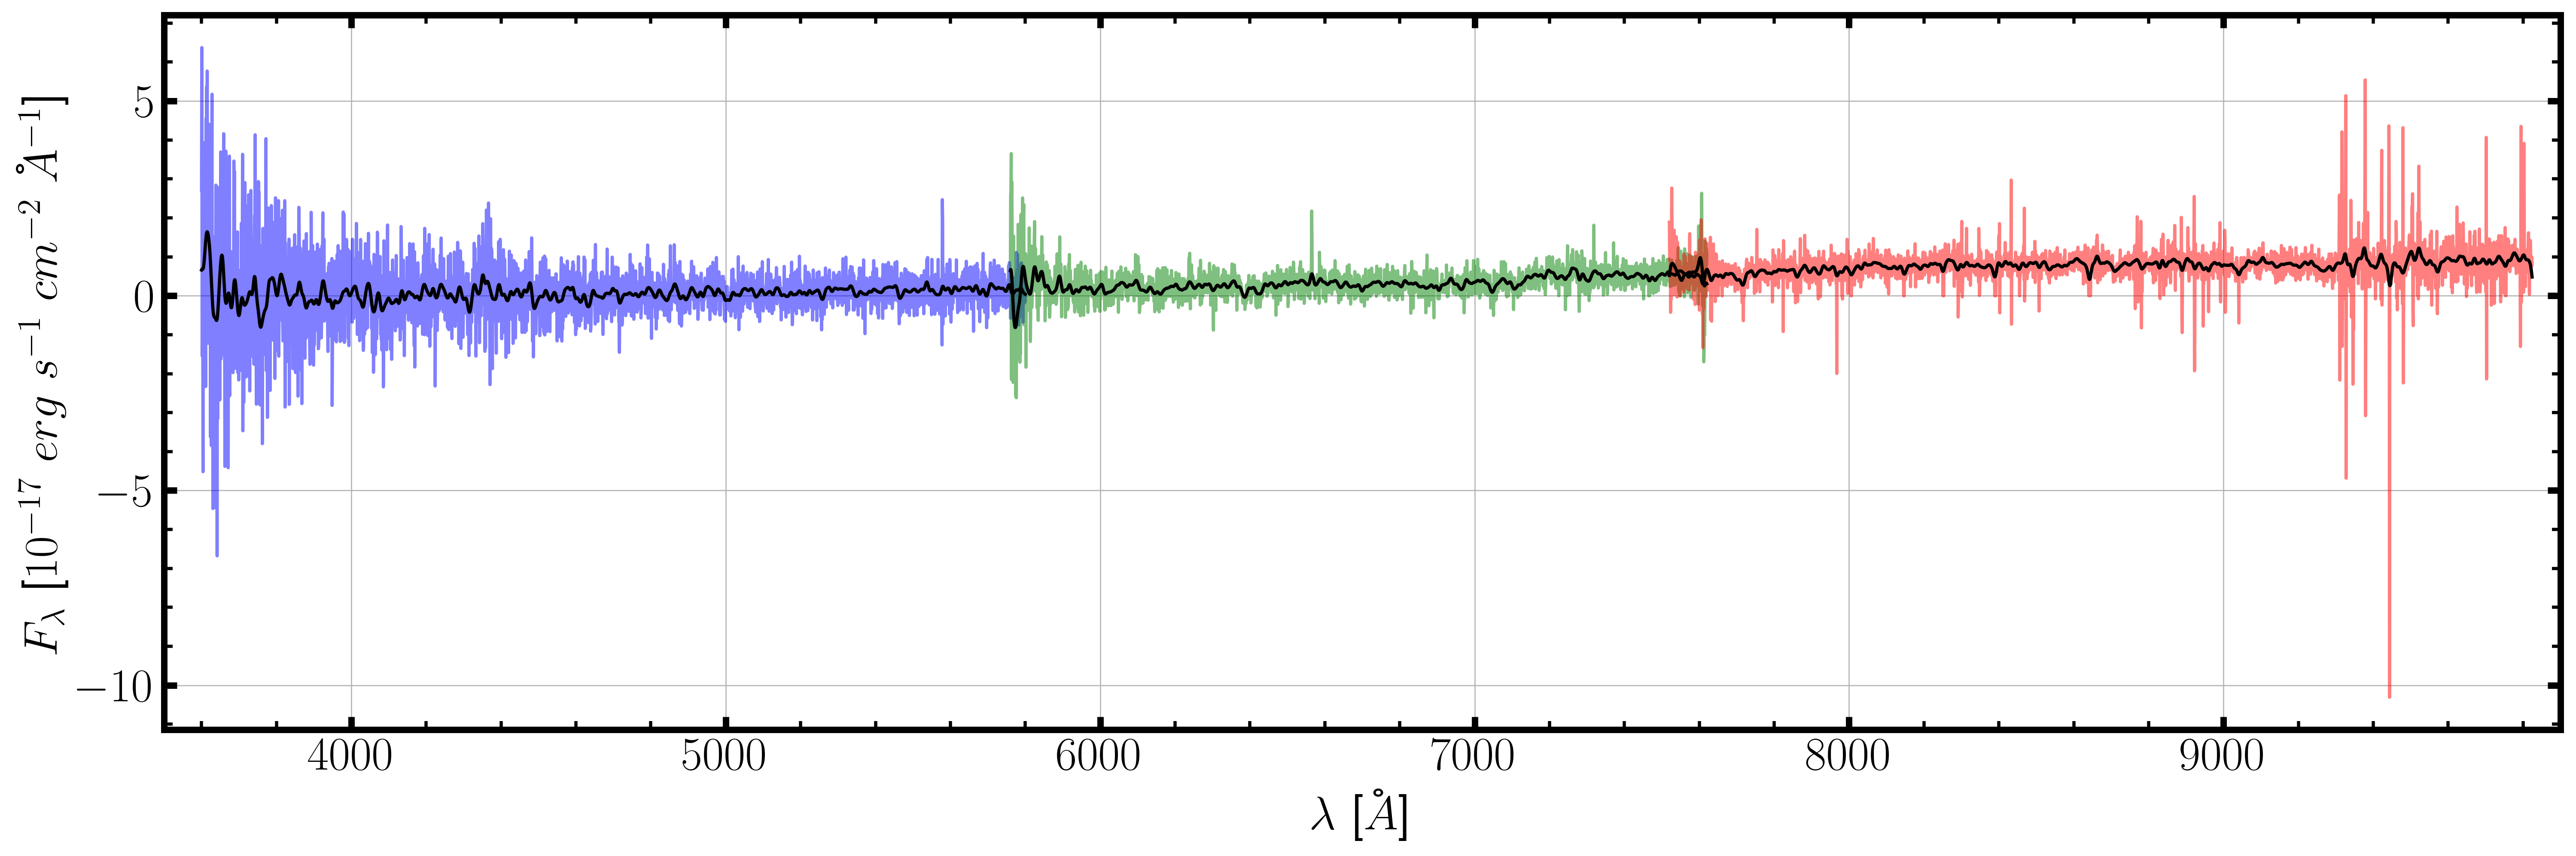

INFO:spectra.py:391:read_spectra: iotime 24.598 sec to read coadd-2-2436-thru20211031.fits at 2025-02-20T16:09:37.876466


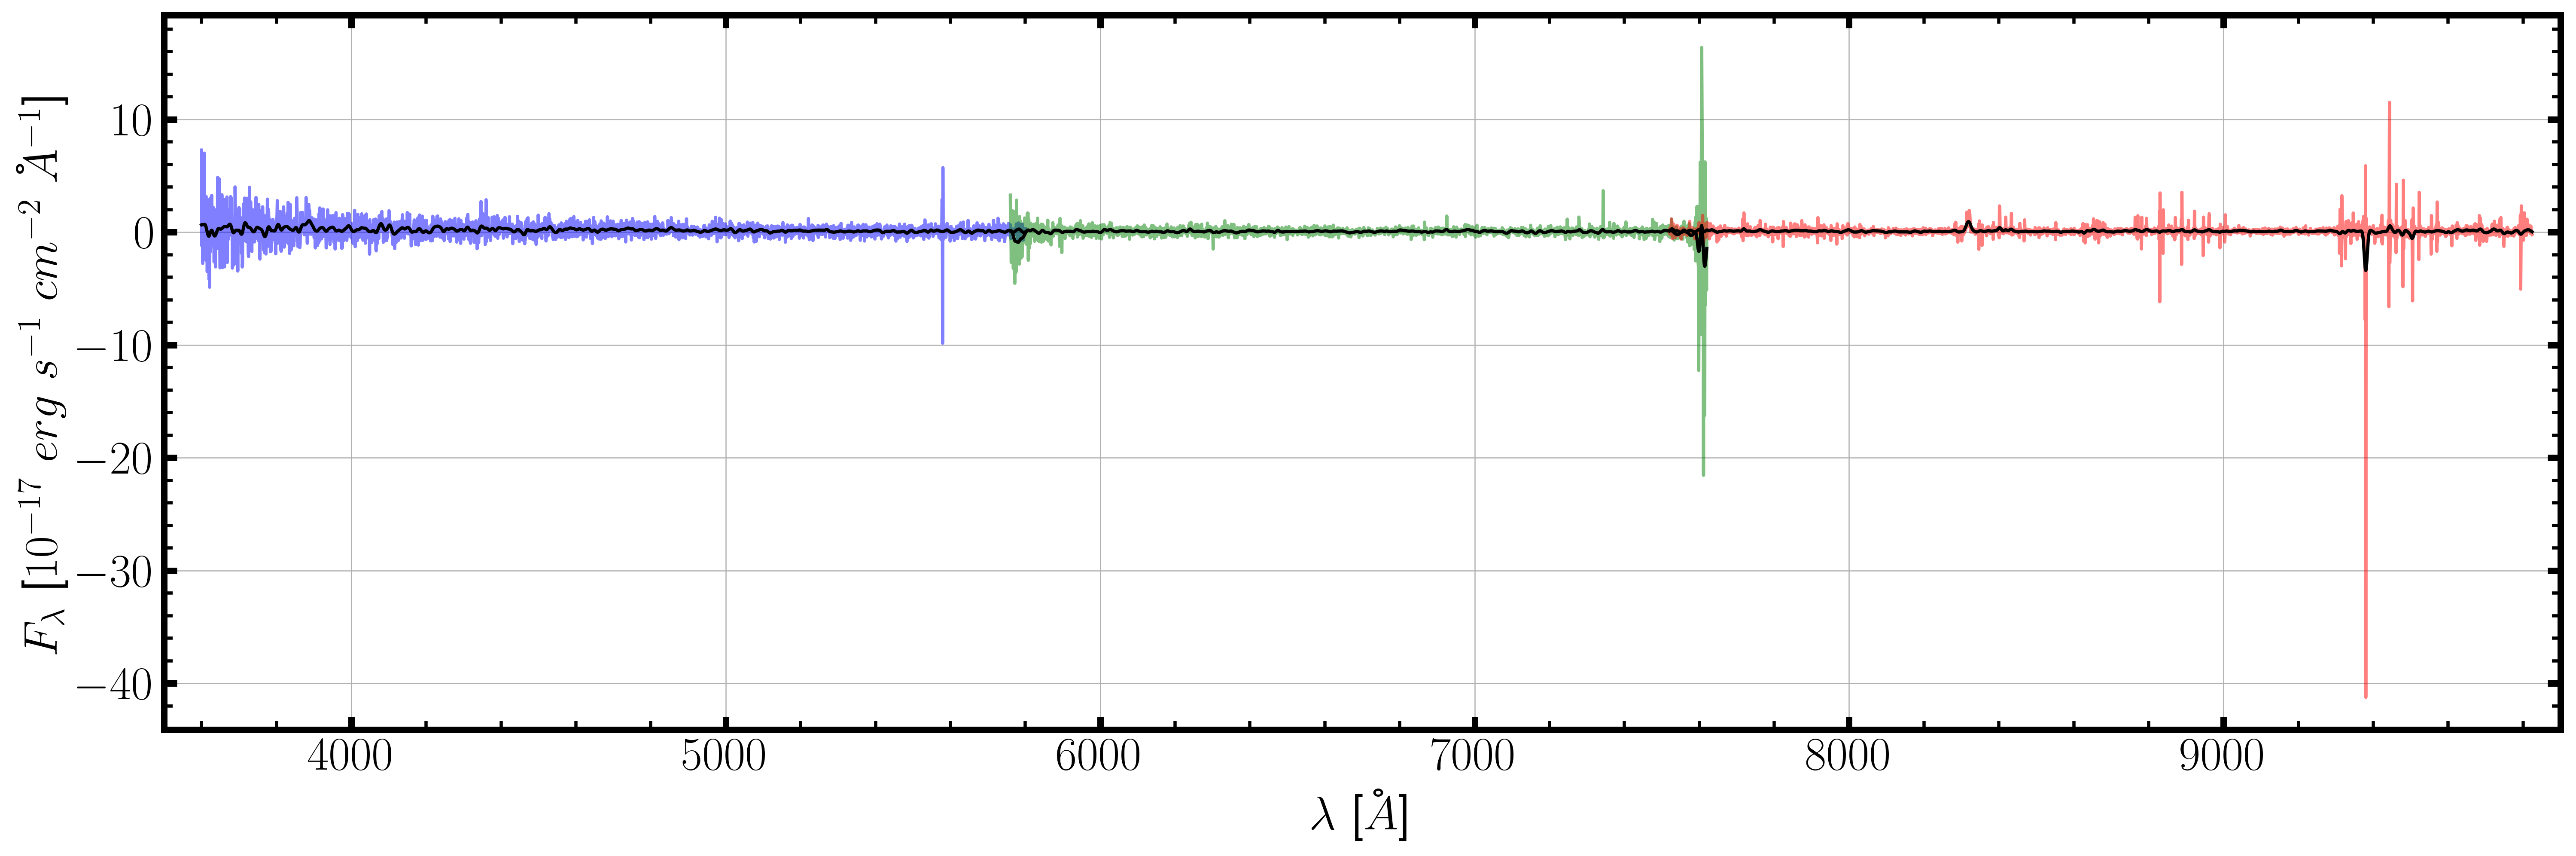

INFO:spectra.py:391:read_spectra: iotime 21.297 sec to read coadd-7-5568-thru20211130.fits at 2025-02-20T16:10:04.074783


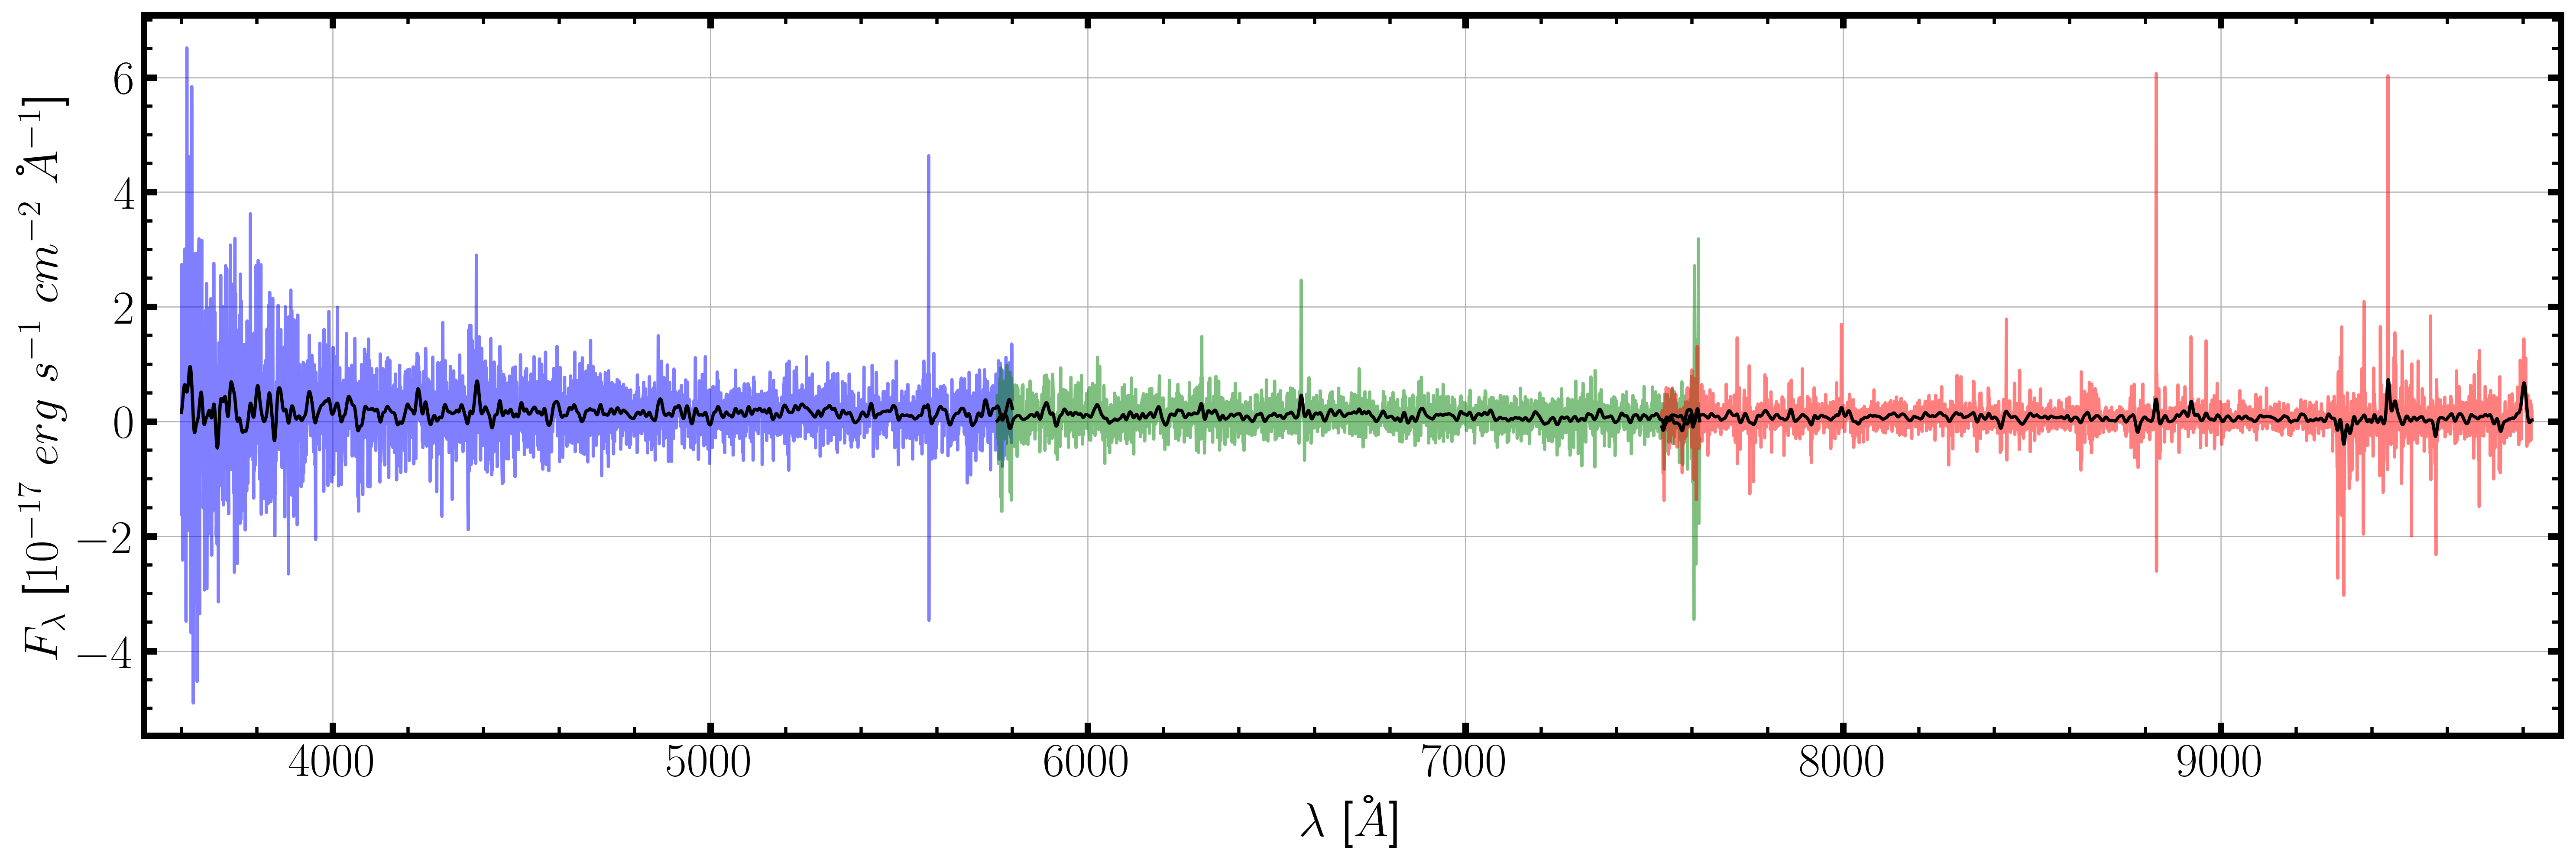

In [178]:
for i, night in enumerate(nights):

    tile = [f for f in os.listdir(f'{data_path}/{tiles_id[i]}/{night}') if f.startswith('coadd-')]

    petal = np.random.choice(tile, 1)[0]
    coadd_obj = desispec.io.read_spectra(f'{data_path}/{tiles_id[i]}/{night}/{petal}')
    coadd_tgts = coadd_obj.target_ids().data

    mask = np.logical_and(coadd_obj.fibermap['COADD_FIBERSTATUS']==0, coadd_obj.fibermap['DESI_TARGET']!=0)
    index = np.where(mask)[0]

    if len(index) > 0:
        tgt = np.random.choice(index)
        coadd_spec = coadd_obj[tgt]

        plot_path = f'./plots/specs/{tiles_id[i]}/{night}'
        if not os.path.exists(plot_path):
            os.makedirs(plot_path)

        if not os.path.exists(f'{plot_path}/{coadd_tgts[tgt]}.png'):
            plt.figure(figsize=(20, 6))

            plt.plot(coadd_spec.wave['b'], coadd_spec.flux['b'][0], color='b', alpha=0.5)
            plt.plot(coadd_spec.wave['r'], coadd_spec.flux['r'][0], color='g', alpha=0.5)
            plt.plot(coadd_spec.wave['z'], coadd_spec.flux['z'][0], color='r', alpha=0.5)

            plt.plot(coadd_spec.wave['b'], convolve(coadd_spec.flux['b'][0], Gaussian1DKernel(5)), color='k')
            plt.plot(coadd_spec.wave['r'], convolve(coadd_spec.flux['r'][0], Gaussian1DKernel(5)), color='k')
            plt.plot(coadd_spec.wave['z'], convolve(coadd_spec.flux['z'][0], Gaussian1DKernel(5)), color='k')

            plt.xlim([3500, 9900])
            plt.xlabel(r'$\lambda$ [$\AA$]')
            plt.ylabel(r'$F_{\lambda}$ [$10^{-17}\ erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
            plt.grid(linewidth=0.5)
            plt.savefig(f'{plot_path}/spec_{petal.split("-")[1]}_{coadd_tgts[tgt]}.png', dpi=360)
            plt.show()
